In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# $\star$ $\star$ Question 1:
Implement the message passing method in the disparity estimation setting. Each pixel can take 16 labels (disparities in the Tsukuba pair range from 0 to 15). 


For the unary cost take the exponential of the Euclidean distance between the pixel colors in the two images. For each pixel in the left image, you must compute 16 costs corresponding to the 16 disparity options. 

Consider the image as an undirected graph, where all pixels are connected only to their direct left and right neighbor. For the pairwise potential use the Potts model (0 cost if the disparity is the same, v else).

Run the message passing algorithm to find the solution with the highest probability. Visualize this result and play with the parameter v

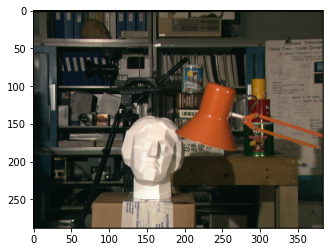

In [10]:
# Read Images
imageL = Image.open('../data/tsukubaL.ppm')
imageR = Image.open('../data/tsukubaR.ppm')
plt.imshow(imageL)

In [11]:
iL = np.asarray(imageL)
iR = np.asarray(imageR)
print(iL[0][100], iR[0][100])
print(np.max(iL), np.min(iL), np.max(iR), np.min(iR))

[2 4 2] [1 4 2]
255 0 255 0


In [104]:
MAX_DISP = 16 

def shift_image_x(img, shift):
    """ 
    shifts image in +ve x direction
    assumes image has shape: h x w x c 
    """
    return np.roll(img, shift, axis=1)

def data_term(im1, im2):
    diff = np.linalg.norm(im1 - im2, axis=-1)
    exp_diff = np.exp(diff)
    return exp_diff

def compute_data_cost(imgL, imgR):
    h, w, _ = imgL.shape
    data_cost = np.zeros((h, w, MAX_DISP))

    for d in range(MAX_DISP):
        shifted_imgR = shift_image_x(imgR, d)
        data_cost[:, :, d] = data_term(imgL, shifted_imgR)
    return data_cost

def s_cost(d, x, y, c, k):
    v = 1.0
    cost = 0.0
    count = 0
    col = y
    while y - 1 >= 0 and count < k:
        if d[x, col, c] != d[x, y - 1, c]:
            cost += v
        y -= 1
        count += 1
    count = 0
    y = col
    while y + 1 < d.shape[1] and count < k:
        if d[x, col, c] != d[x, y + 1, c]:
            cost += v
        y += 1
        count += 1
    return cost
        
    
def compute_smoothness_cost(d):
    smoothness_cost = np.zeros(d.shape)
    for c in range(d.shape[2]):
        for row in range(d.shape[0]):
            for col in range(d.shape[1]):
                smoothness_cost[row, col, c] = s_cost(d, row, col, c, 10)
    return smoothness_cost
                
def compute_msg_fwd(total_cost):
    msg_fwd = np.ones(total_cost.shape)
    for c in range(MAX_DISP):
        msg_fwd[:, 1:, c] = np.exp(-total_cost[:, 0:total_cost.shape[1] - 1, c])
    return msg_fwd
    
def compute_msg_bwd(total_cost): 
    msg_bwd = np.ones(total_cost.shape)
    for c in range(MAX_DISP):
        msg_bwd[:, 0:total_cost.shape[1] - 1, c] = np.exp(-total_cost[:, 1:total_cost.shape[1], c])
    return msg_bwd

def extract_disparity(belief):
    return np.argmax(belief, axis=2)
        
def compute_disparity(imgL, imgR):
    h, w, _ = imgL.shape
    
    data_cost = compute_data_cost(imgL, imgR)
    smoothness_cost = compute_smoothness_cost(data_cost)
    total_cost = data_cost + smoothness_cost
    
    msg_fwd  = compute_msg_fwd(total_cost)
    msg_bwd  = compute_msg_bwd(total_cost)
    
    #aggregate costs
    belief = msg_fwd * msg_bwd
    
    # extract disparites      
    disparity = extract_disparity(belief)

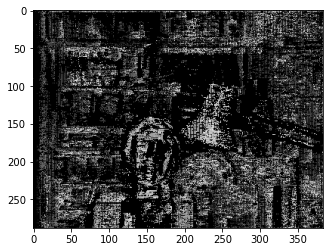

In [105]:
data_cost = compute_data_cost(iL, iR)

smoothness_cost = compute_smoothness_cost(data_cost)

msg_fwd = compute_msg_fwd(data_cost + smoothness_cost)

msg_bwd = compute_msg_bwd(data_cost + smoothness_cost)

belief = msg_fwd * msg_bwd

disp = extract_disparity(belief)
plt.imshow(disp * 16, cmap='gray', vmin=0, vmax=255)

# $\star$ $\star$ $\star$ Question 2: 

Run loopy belief propagation after adding pairwise potentials to vertical neighbors.

Visualize also intermediate results every few iterations. 

Does the process converge to a stable solution?